# Векторный поиск в задаче матчинга

В нашем распоряжении датасет с векторами, описывающими некоторые характеристики товара (его изображение, текстовая информация). Нужно сопоставить векторы друг с другом, это поможет упростить процесс заведения карточек товара на маркетплейсе. Для этого необходимо провести исследовательский анализ данных, их предобработку и оптимизировать векторный поиск для достижения максимального значения полноты. Используемая метрика Recall@10 - означает общую сумму найденных в топ10 кандидатов матчей / общую сумму матчей.

## Исследовательский анализ данных

Импортируем библиотеки:

In [1]:
import pandas as pd
import faiss
import numpy as np
from sklearn.preprocessing import QuantileTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import notebook
import warnings

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('max_columns', None)
pd.set_option('display.max_rows', None)

np.random.seed(42)
SEED = 42

Считаем датасеты:

In [3]:
base = pd.read_csv('base.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Посмотрим на имеющиеся данные:

In [4]:
def total_view(df: pd.DataFrame, n_rows=5, seed=None):
    '''Возвращает первые, случайные и последние строки таблицы (по умолчанию по 5 строк)'''
    return display(pd.concat([
                              df.head(n_rows),
                              df.sample(n_rows, random_state=SEED),
                              df.tail(n_rows)
                             ]))

for name, table in zip(['base', 'train', 'test'], [base, train, test]):
    print(name)
    total_view(table)
    display(table.describe().T)
    table.info()

base


,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.06151,-32.458237,-57.420560,36.207405,182.716770,-28.071688,-5.209374,-1.732182,-91.09186,-79.466670,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.005040,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.34058,-123.626080,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.513610,-44.659496,-80.442210,5.149714,-64.518950,-138.777630,-42.808693,38.800827,-151.76218,-74.389090,63.666340,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.30435,-126.768900,-68.853530,8.314717,143.081740,8.778257,15.157185,48.246360,-244.95486,-80.279420,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.369950,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.55263,-110.340170,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.777050,58.887608,-71.595340,-251.952358,11.392853,-148.571660,-117.767525,41.100000,-157.82940,-94.446806,68.202110,24.346846,179.937930,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.82245,-22.486748,-51.666990,2.521726,140.585450,-22.039230,-7.128634,-5.184787,-111.71212,-79.029270,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.38771,-21.483440,-144.845370,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.06166,-118.758550,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.32137,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.733890,65.320880,-114.037180,-529.396956,-101.581375,-134.658220,-76.397800,46.011803,-207.14442,127.325570,65.566180,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3,3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.47044,-104.537780,-82.388490,-79.986740,113.596310,-38.995880,-4.787360,8.327808,-124.85576,-79.109020,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.20198,10.613454,-134.934340,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.04530,-124.295770,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.76927,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.314320,7.912551,-62.188920,-540.321044,-89.588715,-149.326690,-70.647940,-6.358921,-147.20105,-37.692750,66.202890,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4,4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.34245,-38.982060,-50.228867,-26.690920,135.272900,-7.510103,8.924209,111.576950,-130.83319,-79.315850,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.38553,-44.059470,-148.131850,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.37244,-123.708980,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.54037,57.695343,-67.822630,-29.389133,-34.123740,54.710550,-26.032013,90.673910,58.086998,-134.782060,77.620390,-176.615880,-529.762

,count,mean,std,min,25%,50%,75%,max
0,2918139.0,-86.229474,24.891320,-199.468700,-103.065438,-86.231500,-69.256577,21.515549
1,2918139.0,8.080077,4.953387,-13.914608,4.708491,8.038950,11.470066,29.937210
2,2918139.0,-44.580804,38.631660,-240.073400,-69.559490,-43.816605,-19.625266,160.937230
3,2918139.0,-146.634991,19.844805,-232.667140,-159.905060,-146.776810,-133.327655,-51.374780
4,2918139.0,111.316628,46.348090,-105.582960,80.507945,111.873000,142.374275,319.664500
5,2918139.0,-71.991376,28.186068,-211.008600,-91.379940,-71.922300,-52.441105,58.806244
6,2918139.0,-392.223854,271.654995,-791.469870,-629.331823,-422.201616,-156.668583,109.632533
7,2918139.0,20.352829,64.216382,-301.859740,-22.221474,20.804773,63.918212,341.228200
8,2918139.0,123.684234,6.356109,93.153046,119.483983,123.892250,127.970480,152.261200
9,2918139.0,124.458053,64.430576,-173.871950,81.767510,123.497696,167.220605,427.542050


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      float64
 39  38      float64
 40  

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.936680,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,-88.082690,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.841370,-78.512180,-94.428940,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.821840,149.71584,-27.042316,-133.21217,106.420746,-303.939233,48.730790,58.185707,24.250950,-151.22410,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.991640,-31.948470,82.314430,-115.830470,-243.309390,6.622036,-132.197660,68.712560,-38.806824,62.937435,-132.65445,89.189026,87.039780,-121.279880,-6.986934,-206.513820,29.485587,-77.029590,-132.386170,-105.427820,70.107360,-155.802570,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.260390,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,-177.605800,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.267030,-78.659430,-92.761490,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.783450,153.35791,48.810093,-115.92215,87.464220,-222.286354,25.124150,91.887140,-30.636870,-136.59314,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.150900,-18.751057,95.315384,-60.093273,-83.820580,37.449867,-23.298859,74.061080,-7.139753,75.862400,-112.04511,82.857730,54.067215,-134.005390,-26.142574,-214.632110,-457.848461,21.459618,-137.411360,-40.812233,4.669178,-151.697710,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.401980,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,-86.346560,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.505680,-78.372925,-69.324480,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.321780,158.76062,0.178065,-183.06967,99.053570,-1018.469545,-51.801120,97.766770,-10.865850,-144.42316,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.639530,-30.211614,48.527400,-122.406640,-112.713620,53.461838,-31.117260,107.841510,16.482935,77.934480,-95.61873,91.460075,63.119510,-126.939250,8.066627,-195.677670,-163.120000,-72.830000,-139.223070,-52.031662,78.039764,-169.146200,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,-146.517070,-159.469850,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.906830,-78.789320,-78.737090,1507.231274,19.957405,34.834290,-8.820732,813.770071,-125.606800,17.584084,-58.452904,141.28180,-54.959310,-136.98854,63.880493,-1018.469545,89.228930,65.919960,-24.078644,-152.33410,-91.199380,-28.225390,-4.767386,0.158236,-129.128660,122.958370,-30.800995,123.623400,-37.540867,-72.139800,71.240990,-168.115590,118.236450,-18.065195,37.255720,-137.69104,87.500770,62.437290,-131.260640,35.692660,-86.038830,-379.339090,-153.465770,-131.198290,-61.567047,44.515266,-145.416750,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.052540,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,-107.153020,-8.800034,-50.977800,29.457338,143.389310,5.614824,-45.274760,9.643625,-77.554630,-79.066610,-77.926460,1507.231274,16.612400,116.284290,33.754898,813.770071,-105.765335,6.523008,-19.812988,157.69392,-20.604088,-146.59128,78.849570,-780.449185,87.560770,73.036660,16.891030,-144.65790,-116.122150,-19.353254,-7.709266,-5.394988,-140.252120,193.184970,-53.147078,79.869446,-151.131350,-45.056160,79.796234,46.763016,47.681810,-24.104229,7

,count,mean,std,min,25%,50%,75%,max
0,100000.0,-85.328679,25.803845,-186.280270,-103.309147,-85.273695,-67.330810,14.585236
1,100000.0,7.664345,4.955651,-11.560507,4.313784,7.652854,10.981191,28.917845
2,100000.0,-43.667046,39.111064,-224.896060,-69.494487,-42.830246,-17.713690,128.108460
3,100000.0,-146.118630,20.434841,-223.307220,-160.028520,-146.067445,-132.277745,-60.751625
4,100000.0,111.770592,47.700958,-93.272020,79.474322,112.260100,143.760830,301.363600
5,100000.0,-73.178792,28.718853,-184.962450,-92.834080,-73.364420,-53.699612,51.849710
6,100000.0,-440.615118,279.017550,-791.469482,-738.536868,-511.837758,-201.116578,109.625188
7,100000.0,21.231588,65.985214,-278.582820,-22.131764,22.278989,65.899595,288.171840
8,100000.0,123.067891,6.492081,94.831150,118.674642,123.087540,127.541802,149.356200
9,100000.0,126.120201,64.912752,-142.156950,82.545028,125.963340,169.701005,392.827150


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 74 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.926790,110.745940,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.892800,-140.968570,-57.987164,-22.868887,150.895520,7.965574,17.622066,-34.868217,-216.138550,-80.908730,-52.579520,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.30708,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.16277,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.124000,-24.996636,76.153900,-245.261570,-143.65648,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.486870,-39.484753,-124.384575,-307.949760,45.506813,-144.190950,-75.513020,52.830902,-143.439450,59.051935,69.282240,61.927513,111.592530,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.417620,114.449910,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.717250,-63.951330,-52.369495,-33.390945,148.619500,-22.483830,15.164185,-56.202000,-153.614380,-79.831825,-101.055480,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.38391,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.53838,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.953950,-18.408230,90.517050,-95.531000,-259.63605,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.075260,-25.169033,-176.176880,-655.836897,-99.238370,-141.535220,-79.441830,29.185436,-168.605900,-82.872443,70.765600,-65.975950,97.077160,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.160930,96.446160,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.309540,-31.378445,-8.788761,2.285323,133.266110,-41.309080,14.305538,-18.231812,-205.533700,-78.160310,-96.607670,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.36850,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.93462,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.276150,-45.909942,103.491360,-90.656990,-162.61570,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.566180,-12.822194,-154.197650,-407.199067,5.522629,-126.812970,-134.795410,37.368730,-159.662310,-119.232725,67.710440,86.002060,137.636410,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.060440,83.697080,-133.729720,58.576403,-19.046660,115.042404,75.206730,-114.271960,-71.406456,-65.349320,24.377070,50.467300,-14.721335,15.069309,-46.682995,-176.604370,-78.690700,-139.227450,325.547112,3.632292,74.929504,-4.802103,813.770071,-52.982597,15.644381,-54.087467,151.30914,21.088570,-134.507890,65.118960,-529.295053,131.565520,67.642700,-22.884491,-145.90652,-86.917330,-11.863579,-22.188885,0.463720,-212.533750,170.522580,-48.092532,99.712555,-194.692410,-141.52318,60.217050,73.386380,118.567856,58.900810,55.569030,-181.091660,83.340485,66.083240,-114.048870,-57.156870,-56.335075,-318.680065,-15.984783,-128.101330,-77.236110,44.100494,-132.530120,-106.318982,70.883960,23.577892,133.183960,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.884950,165.453920,-28.291668,33.931936,34.411217,128.903980,102.086914,-76.214170,-26.393860,34.423640,50.938890,157.683180,-23.786497,-33.175415,-0.592607,-193.318540,-79.651030,-91.889786,1358.481072,44.027733,121.527210,46.183000,433.623103,-82.233200,21.068508,-32.940117,149.26895,0.404718,-97.674530,81.719990,-825.644804,9.397169,49.359340,17.725466,-160.16815,-129.367950,-55.532898,-2.597821,-0.226103,-41.369140,92.090195,-58.626857,73.655440,-10.257370,-175.65678,25.395056,47.874825,51.464676,140.951680,58.751133,-215.487640,91.255370,44.1

,count,mean,std,min,25%,50%,75%,max
0,100000.0,-85.302233,25.777321,-190.353330,-103.231790,-85.296745,-67.422104,14.427986
1,100000.0,7.669724,4.956990,-11.109877,4.292425,7.657888,10.993900,27.409784
2,100000.0,-43.842474,39.138775,-217.538420,-69.680916,-43.230835,-17.765821,134.859800
3,100000.0,-146.119797,20.495541,-220.050890,-160.210287,-146.080365,-132.119278,-57.381890
4,100000.0,111.635071,47.751576,-81.198990,79.101920,111.959330,143.903735,302.065370
5,100000.0,-73.273042,28.515740,-176.705030,-92.789803,-73.579283,-53.861139,50.255325
6,100000.0,-441.396759,279.242585,-791.460243,-740.620025,-513.922978,-202.572440,109.632035
7,100000.0,21.594242,66.478048,-265.608430,-21.804730,22.138012,66.097697,279.468900
8,100000.0,123.077725,6.504931,96.218350,118.657689,123.062568,127.538967,151.822560
9,100000.0,126.001062,64.981697,-135.667300,82.311205,126.083595,169.680500,392.827150


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

- все таблицы содержат колонки с координатами векторов от 0 до 71;
- типы данных в таблицах соответствуют содержащейся в них информации;
- цифра в `Id` вектора из `base` не всегда соответствует индексу соответствующего вектора в таблице, в `train` соответствует, в `test` отличается ровно на 1 млн.
- в `train` в колонке `Target` указаны id матчей из `base`;
- пропущенные значения отсутствуют.
  
Посмотрим на выбросы и распределение данных:

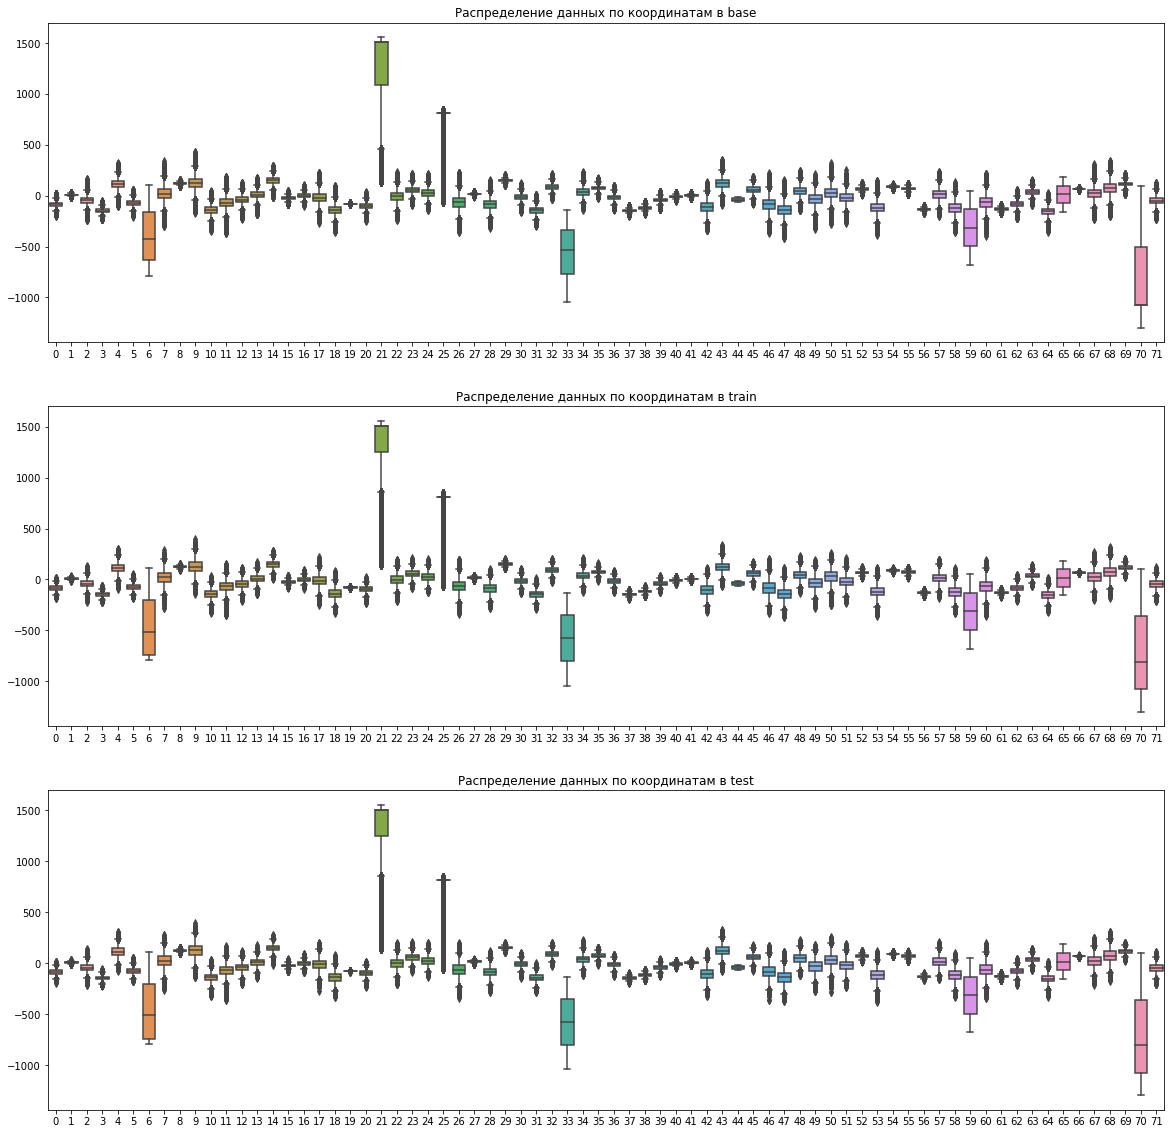

In [5]:
plt.figure(figsize=(20,20))
columns = base.columns[1:].tolist()
cnt = 1
for name, table in zip(['base', 'train', 'test'], [base, train, test]):
    plt.subplot(3, 1, cnt)
    cnt += 1
    sns.boxplot(data=table[columns])
    plt.title(f'Распределение данных по координатам в {name}')

base


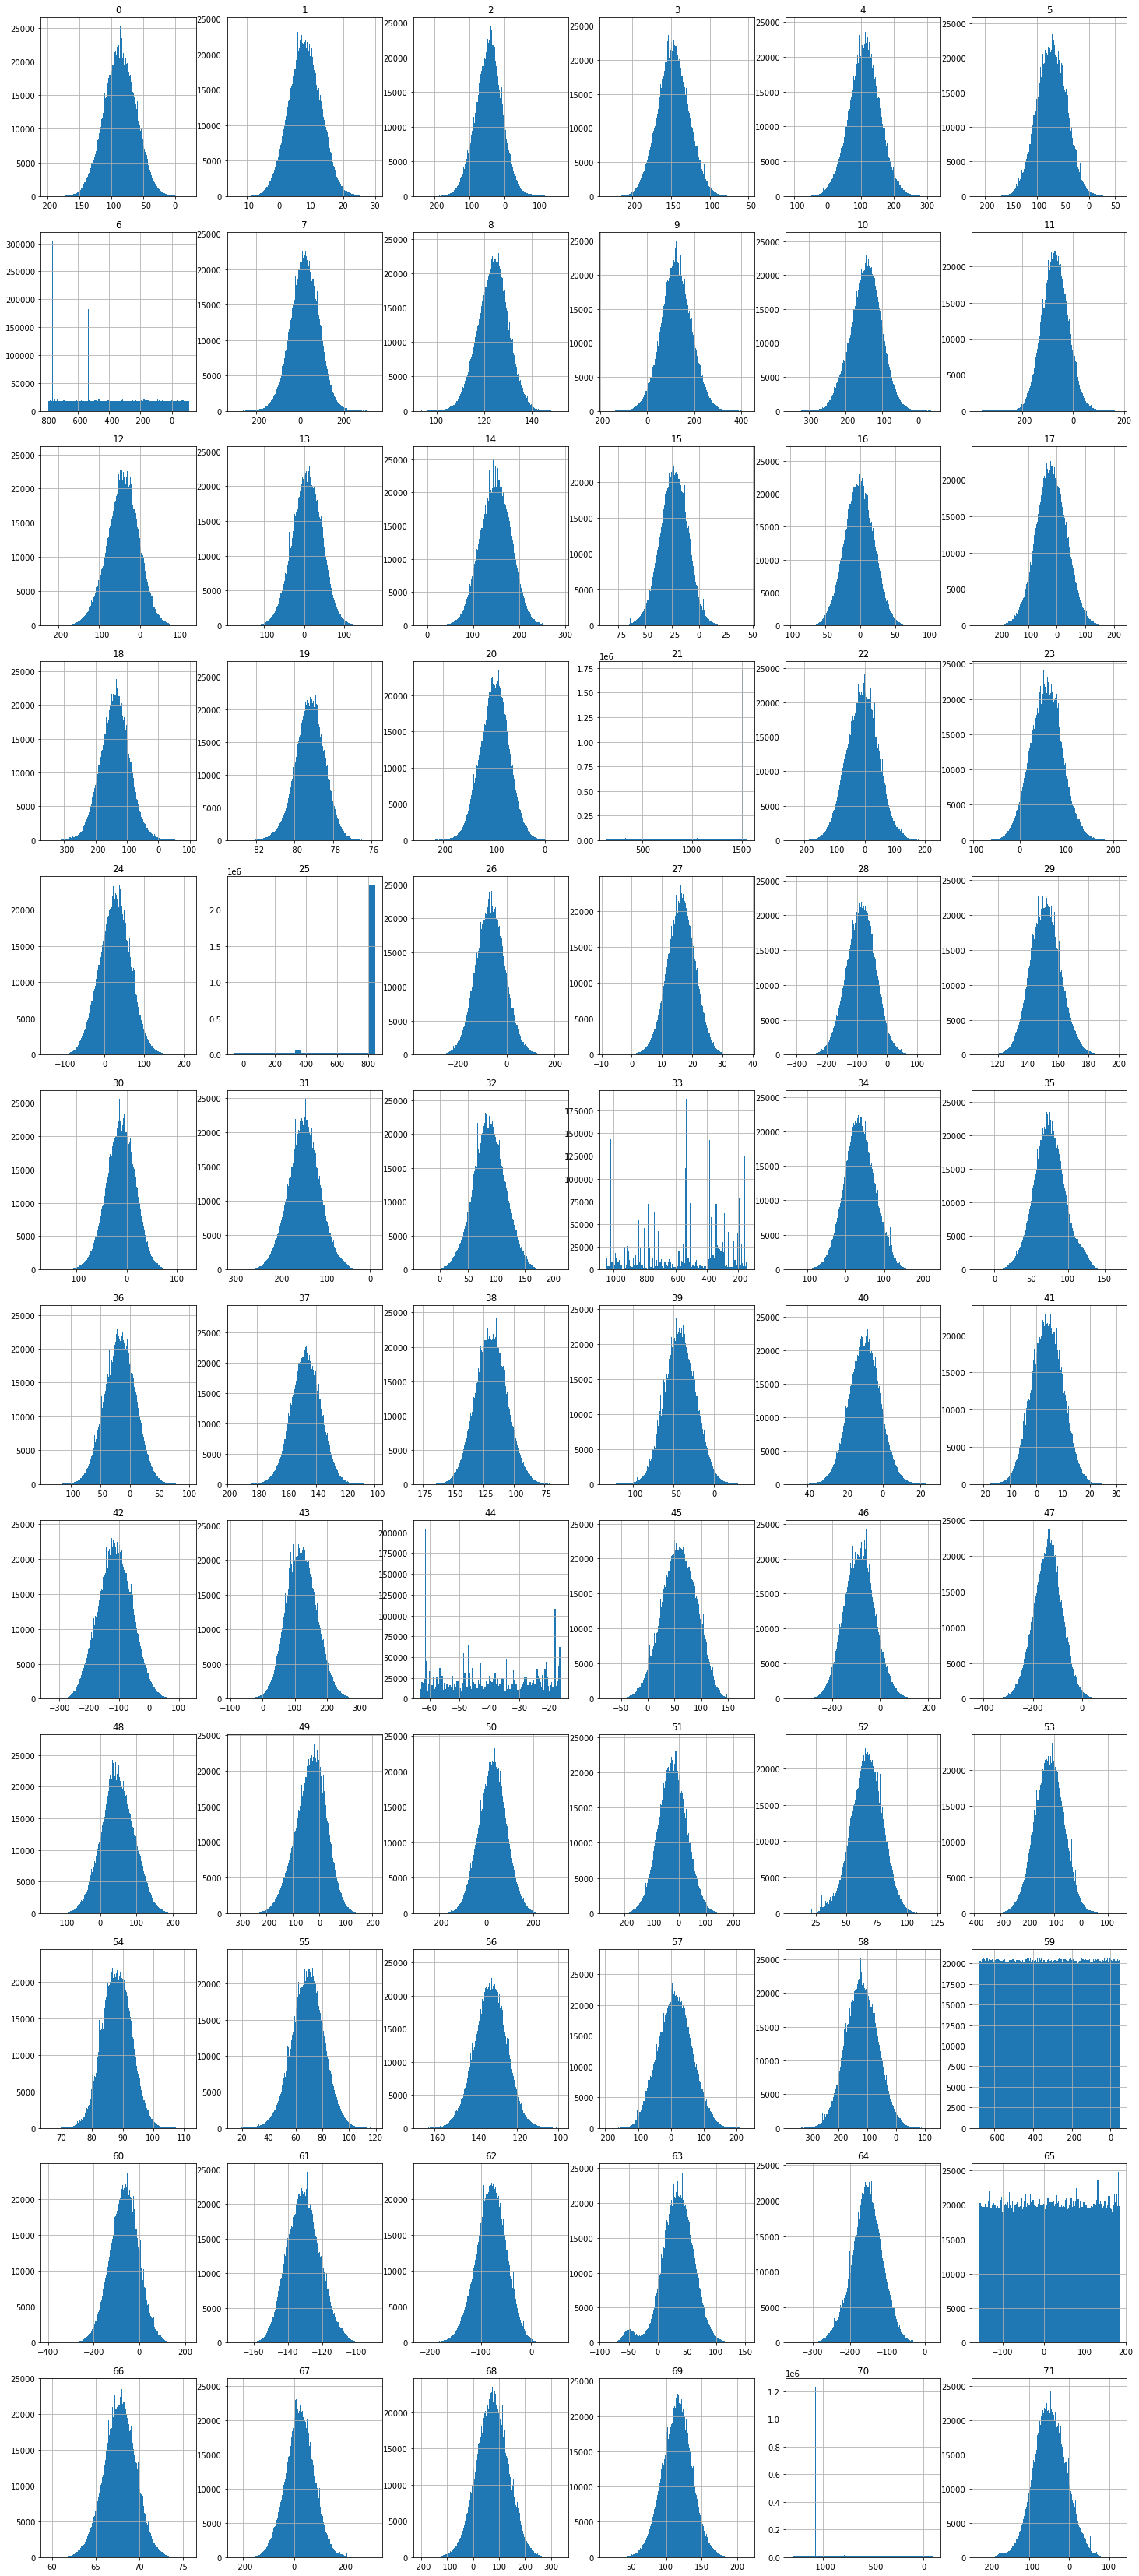

In [6]:
plt.figure(figsize=(25,60))
cnt = 1
print('base')
for col in columns:
    plt.subplot(12, 6, cnt)
    base[col].hist(bins='auto')
    cnt += 1
    plt.title(col)

train


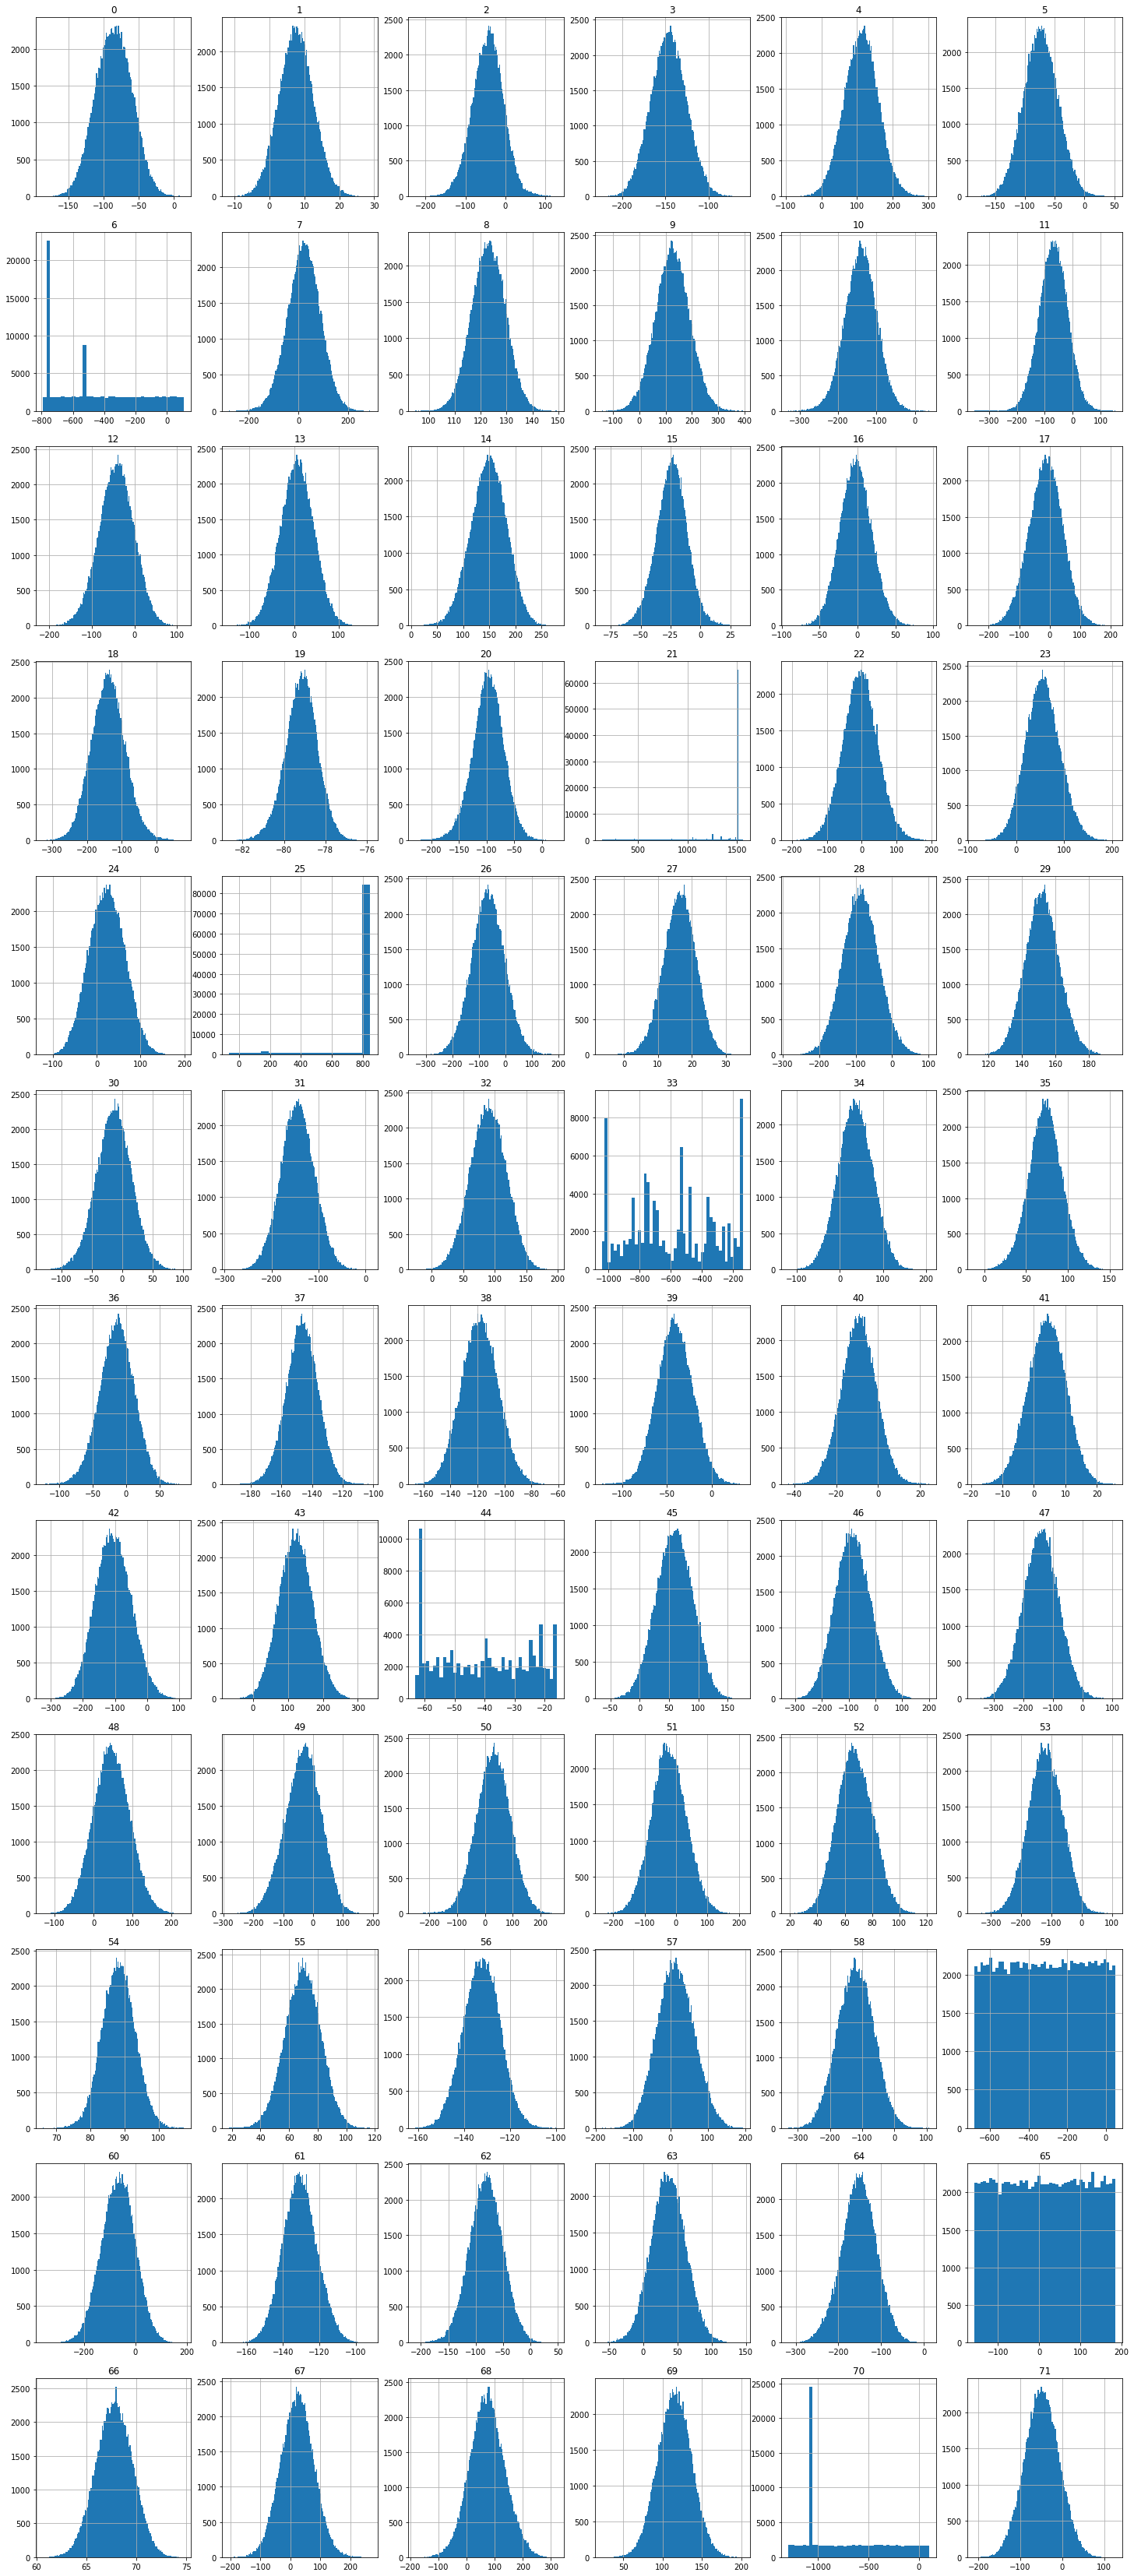

In [7]:
plt.figure(figsize=(25,60))
cnt = 1
print('train')
for col in columns:
    plt.subplot(12, 6, cnt)
    train[col].hist(bins='auto')
    cnt += 1
    plt.title(col)

test


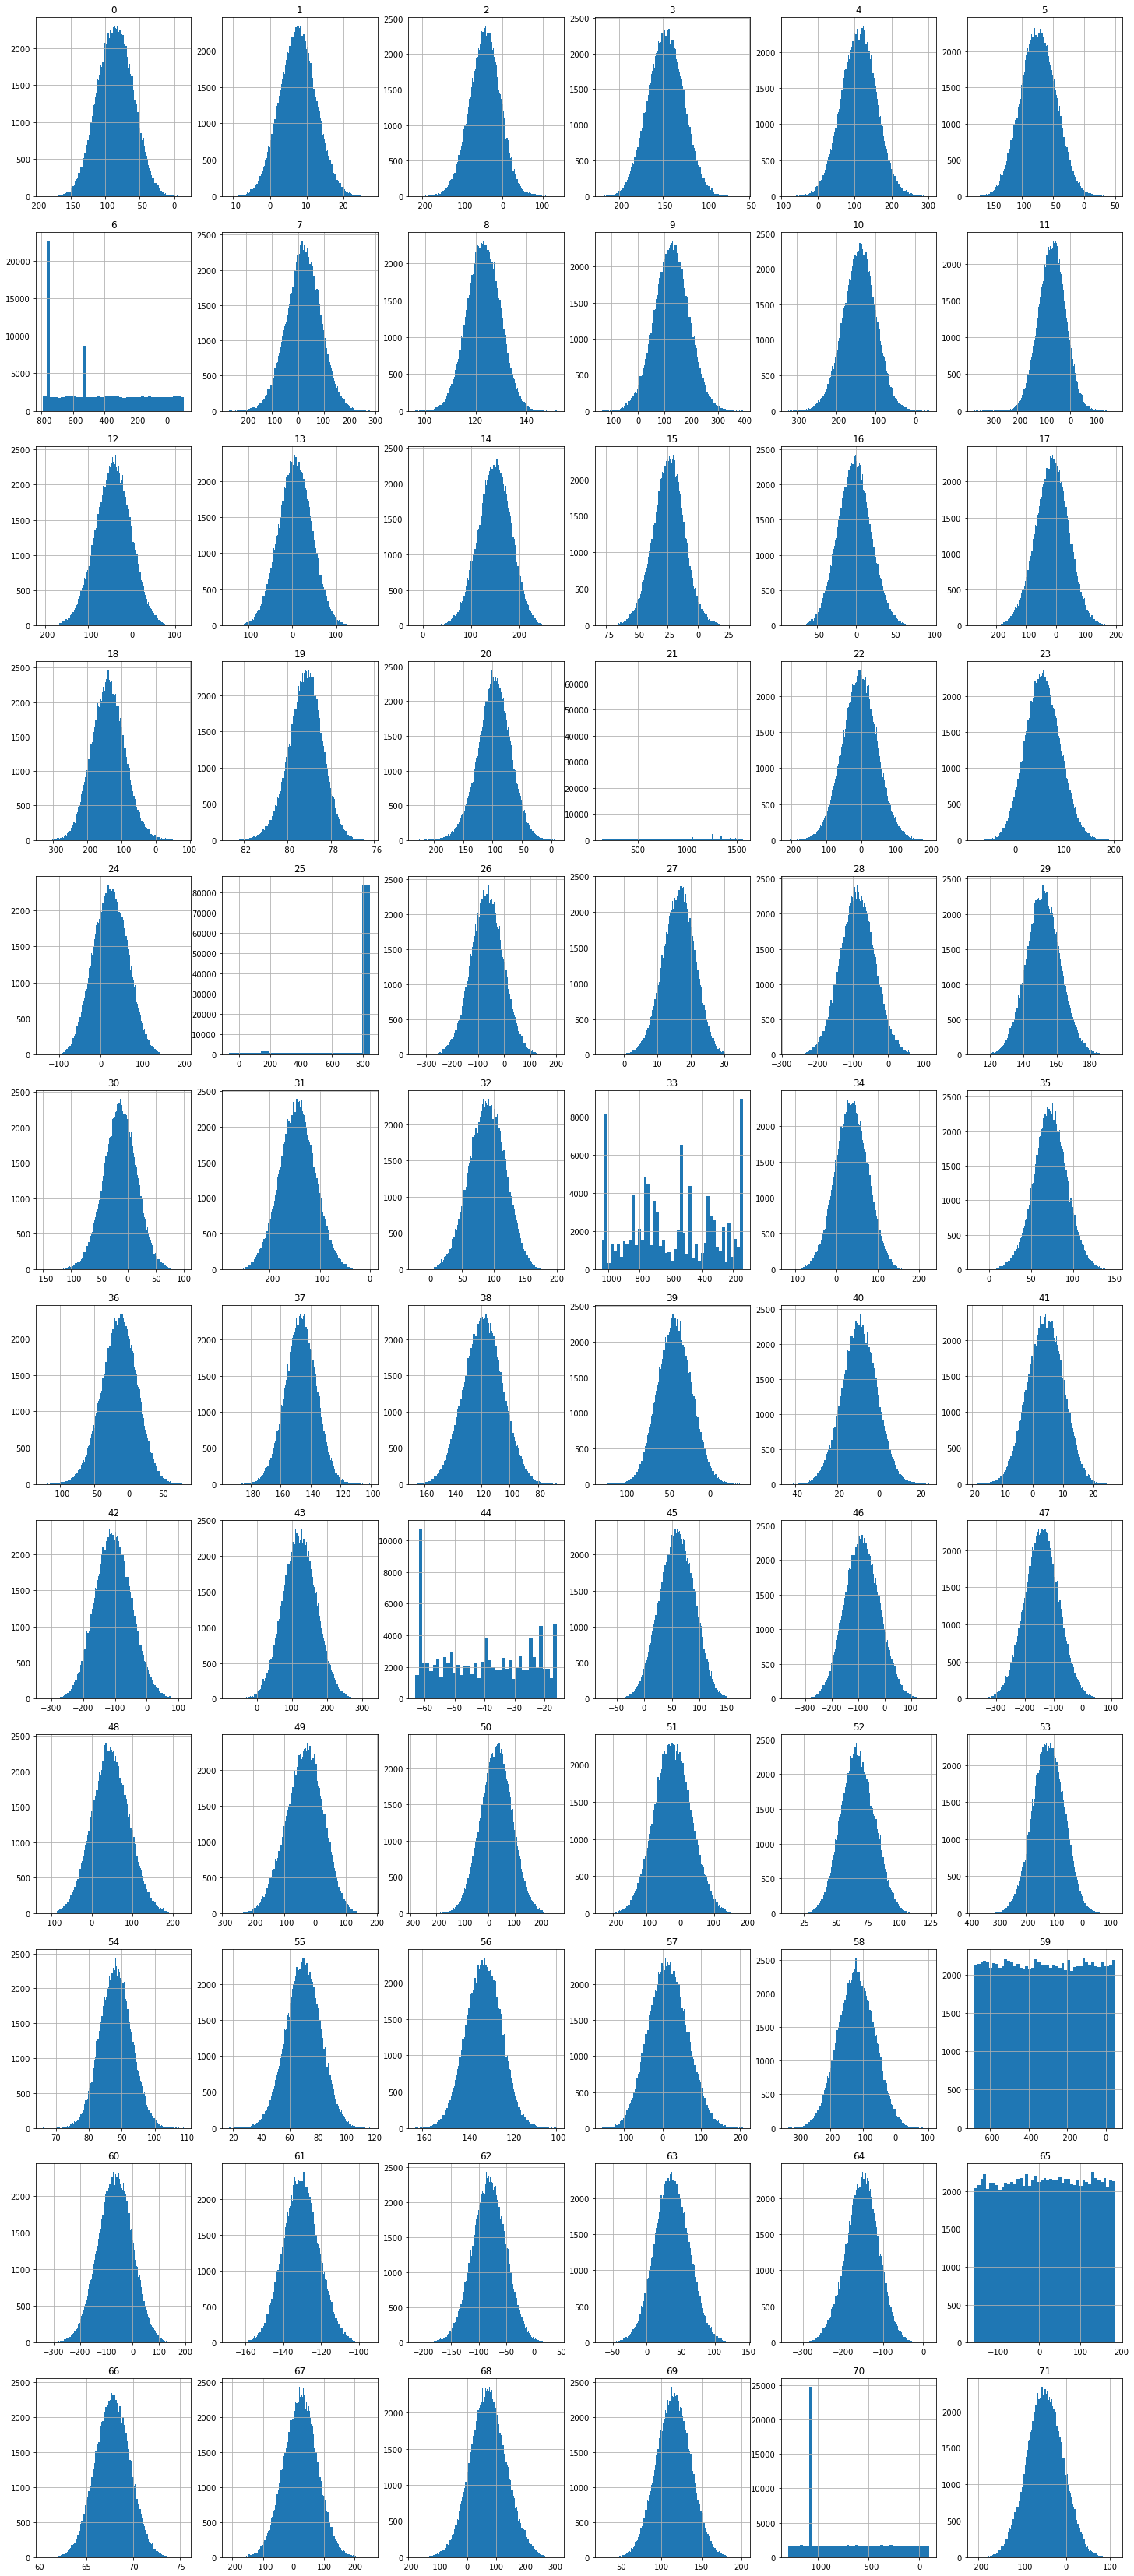

In [8]:
plt.figure(figsize=(25,60))
cnt = 1
print('test')
for col in columns:
    plt.subplot(12, 6, cnt)
    test[col].hist(bins='auto')
    cnt += 1
    plt.title(col)

- большинство значений координат находится в диапазоне примерно ±250, но есть и значительно выходящие из указанного диапазона данные - колонки 6, 21, 25, 33, и 70;
- в большинстве колонок данные распределены нормально;
- в колонках 6, 21, 25, 33, 44 и 70 заметно большое количество данных, сосредоточенных, как правило, около одного или нескольких достаточно больших чисел;
- в колонке 63 таблицы `base` наблюдается небольшая аномалия, похожая на бимодальное распределение, причем обе моды  противоположны друг другу.
  
Рассмотрим колонку 63 таблицы `base` подробнее, выгрузим срез датасета с аномалиями в 63 колонке:

In [9]:
total_view(base[base['63'] < -20])

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
23,23-base,-77.867805,15.520395,-50.470320,-148.17760,103.241500,-64.403050,70.962282,78.849846,125.762640,69.196686,-197.19533,-61.264366,-39.436850,43.160767,115.305390,-2.472349,21.849910,-33.359535,-144.526520,-80.004880,-137.020390,1507.231274,-40.423590,98.568500,10.228567,813.770071,-72.705740,18.357843,-87.102190,149.94215,21.315502,-121.059586,75.019640,-537.183707,34.603260,111.312900,-55.900470,-150.48740,-133.467010,-40.518967,-14.720955,2.856712,-251.87128,60.193573,-18.251750,126.482315,-69.739334,-140.319500,117.244125,-23.692219,17.115349,-82.121160,63.791573,-112.262850,94.913124,76.933685,-128.87529,-102.666890,-136.26971,-122.047176,-77.548870,-140.81355,-78.513060,-42.219130,-151.24487,66.307397,70.280790,10.237137,54.975510,112.591930,-475.656201,-32.404655
33,33-base,-104.946790,15.243933,-34.983720,-153.39099,91.821594,-52.730797,-66.314101,3.670305,128.649870,104.854004,-205.63300,-62.558020,-16.444134,49.454384,127.075195,-2.542490,8.545102,-54.148310,-126.915310,-79.811480,-137.453480,1507.231274,-77.987830,57.855120,31.493443,813.770071,-69.881996,20.223644,-79.438225,140.06828,16.041374,-134.140900,67.271680,-537.183707,24.549305,121.597980,-45.973793,-158.18582,-131.607740,-38.378048,-14.446618,3.067395,-241.44957,87.305390,-18.251750,76.295050,-12.828438,-161.372130,96.321210,28.950417,0.543381,-54.552994,62.304176,-152.681640,88.373055,66.691260,-130.35450,-56.177425,-222.77405,-125.176767,-65.699310,-145.21014,-90.763916,-61.652330,-155.89020,95.390194,69.161900,23.001680,83.906940,122.420500,-677.214294,-41.359860
86,86-base,-93.610480,13.602272,-59.562244,-149.16438,121.595240,-47.643166,-86.879912,66.725340,122.309300,136.434520,-231.03056,-97.348274,-38.436512,56.648247,106.245476,-1.232090,35.719105,-25.079030,-95.167890,-80.531270,-112.942430,1507.231274,-73.542160,83.609910,73.635360,813.770071,-25.780811,17.562397,-71.588000,146.96002,-7.094880,-136.874270,74.485050,-537.183707,-0.703541,114.391510,-26.679665,-158.09328,-120.592290,-53.128933,-22.691261,3.528644,-217.58798,60.490837,-18.251750,107.855510,-116.549670,-107.244020,101.180970,-5.780292,53.307860,-35.819710,65.715810,-110.368540,89.994980,79.108890,-140.95634,-88.035640,-172.11730,-163.621473,-34.244070,-138.79448,-88.215940,-50.561157,-143.85922,-125.035852,68.867480,17.947750,78.945790,119.825640,-108.932696,-100.731766
111,111-base,-89.802750,14.188639,-23.970984,-155.54580,100.727050,-45.471870,-603.298803,84.851074,126.872790,86.699930,-200.54382,-90.350950,-40.581390,51.036575,97.523660,-4.753227,17.212631,-43.975860,-124.070760,-79.481420,-138.525540,1507.231274,-73.363400,80.804565,50.225770,813.770071,-70.016235,16.154573,-93.385320,143.84730,10.107783,-145.740840,64.686676,-537.183707,29.360357,125.247680,-60.322895,-156.52602,-127.586290,-48.907898,-18.042128,1.673719,-204.68034,77.554660,-18.251750,97.471760,-65.321590,-136.794220,135.063520,12.546814,71.297240,-20.736794,69.759660,-81.329970,91.091850,71.866264,-132.59967,-103.248120,-153.81769,-312.611319,-96.268745,-146.25941,-82.368860,-61.622635,-151.60835,13.318125,68.533554,-29.941540,100.729140,111.155810,34.953410,-64.336130
124,124-base,-107.332100,11.674377,-47.365650,-151.90819,120.056100,-40.265010,-756.708301,-1.578846,126.483230,74.216510,-222.07270,-90.401360,-81.224205,16.426943,121.273180,-12.095522,26.438805,-63.568954,-109.054460,-79.760890,-144.747710,1507.231274,-51.676510,79.080660,27.113962,813.770071,-19.056130,16.612505,-84.032250,131.67960,25.304398,-159.813500,62.516228,-537.183707,38.500360,118.807210,-47.340836,-151.61850,-127.447440,-39.228992,-16.283388,2.815570,-183.44437,81.972700,-18.251750,122.277145,-52.961052,-112.806625,125.282410,-17.125088,62.803524,-3.065498,68.582430,-102.863910,88.757320,77.058510,-129.89650,-69.43

Если не брать в расчет одинаковые значения наподобие 1507.231274 из 21 колонки или -537.183707 из 33й, которые, судя по гистограммам, повторяются для большого количества векторов, то остается число -18.25174973700229 из колонки 44. Добавим его в логическую индексацию и сравним полученные распределения данных в колонке 63:

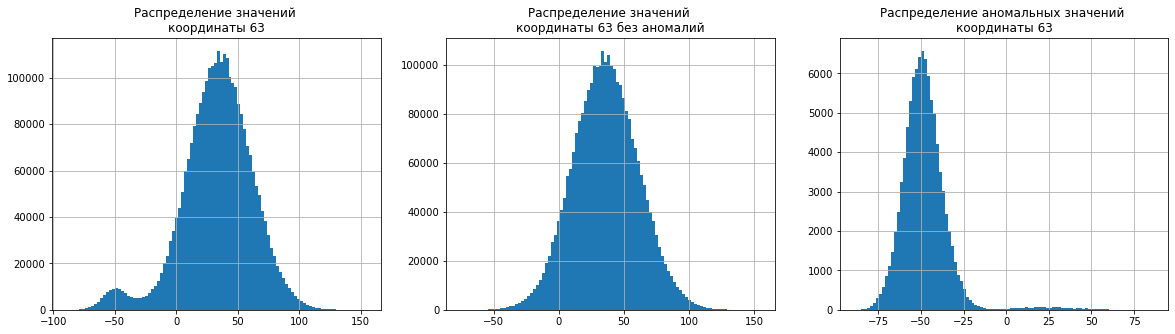

In [10]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
base['63'].hist(bins=100)
plt.title('Распределение значений \nкоординаты 63')

plt.subplot(1, 3, 2)
base[base['44'] != -18.25174973700229]['63'].hist(bins=100)
plt.title('Распределение значений \nкоординаты 63 без аномалий')

plt.subplot(1, 3, 3)
base[base['44'] == -18.25174973700229]['63'].hist(bins=100)
plt.title('Распределение аномальных значений \nкоординаты 63')
None

Судя по гистограммам, аномальные значения действительно похожи на ошибку в данных и при умножении на -1 вернутся к изначальному распределению. Умножим их на -1:

In [11]:
base.loc[base['44'] == -18.25174973700229, '63'] = -1 * base['63']

Посмотрим на топ-5 повторящихся значений для каждой координаты:

In [12]:
for col in columns:
    print(base[[col]].value_counts()[:5], sep='\n')

0         
-85.798134    3322
-81.488540    2600
-75.790700    2371
-58.882553    2073
-73.955790    1994
dtype: int64
1        
13.568428    3322
9.422560     2599
5.845439     2371
8.213248     2072
9.178744     1994
dtype: int64
2         
-53.606680    3322
-8.807152     2599
-27.186830    2371
 1.279209     2072
-39.541300    1994
dtype: int64
3         
-149.43290    3323
-131.36623    2600
-156.60160    2372
-149.53960    2072
-127.68569    1994
dtype: int64
4        
138.07822    3322
183.20691    2599
94.27618     2371
108.38418    2072
133.24327    1994
dtype: int64
5          
-72.410310     3323
-70.375680     2600
-100.656815    2371
-88.129170     2072
-92.858505     1994
dtype: int64
6          
-759.626065    287090
-530.124724    164815
-175.047853      3707
-92.055125       3622
-750.151074      2659
dtype: int64
7         
 44.749210    3322
-53.776810    2599
 21.891655    2371
 17.640469    2072
 76.655525    1994
dtype: int64
8         
125.561195    3323
127.9248

Среди количества уникальных значений часто встречаются по 3322, 2599, 2371 и тд одинаковых значений, что указывает на синтетическое происхождение данных. В колонках 6, 21, 25, 33, 44 и 70 количество повторяющихся значений слишком велико, это может сильно исказить рассчитываемое между векторами расстояние. Эти признаки мы удалим как неинформативные. Распределение данных в колонках 59 и 65 равномерное и не похоже на остальное большинство. Без них рассчитываемая метрика также становится чуть больше.

Посмотрим на корреляцию признаков:

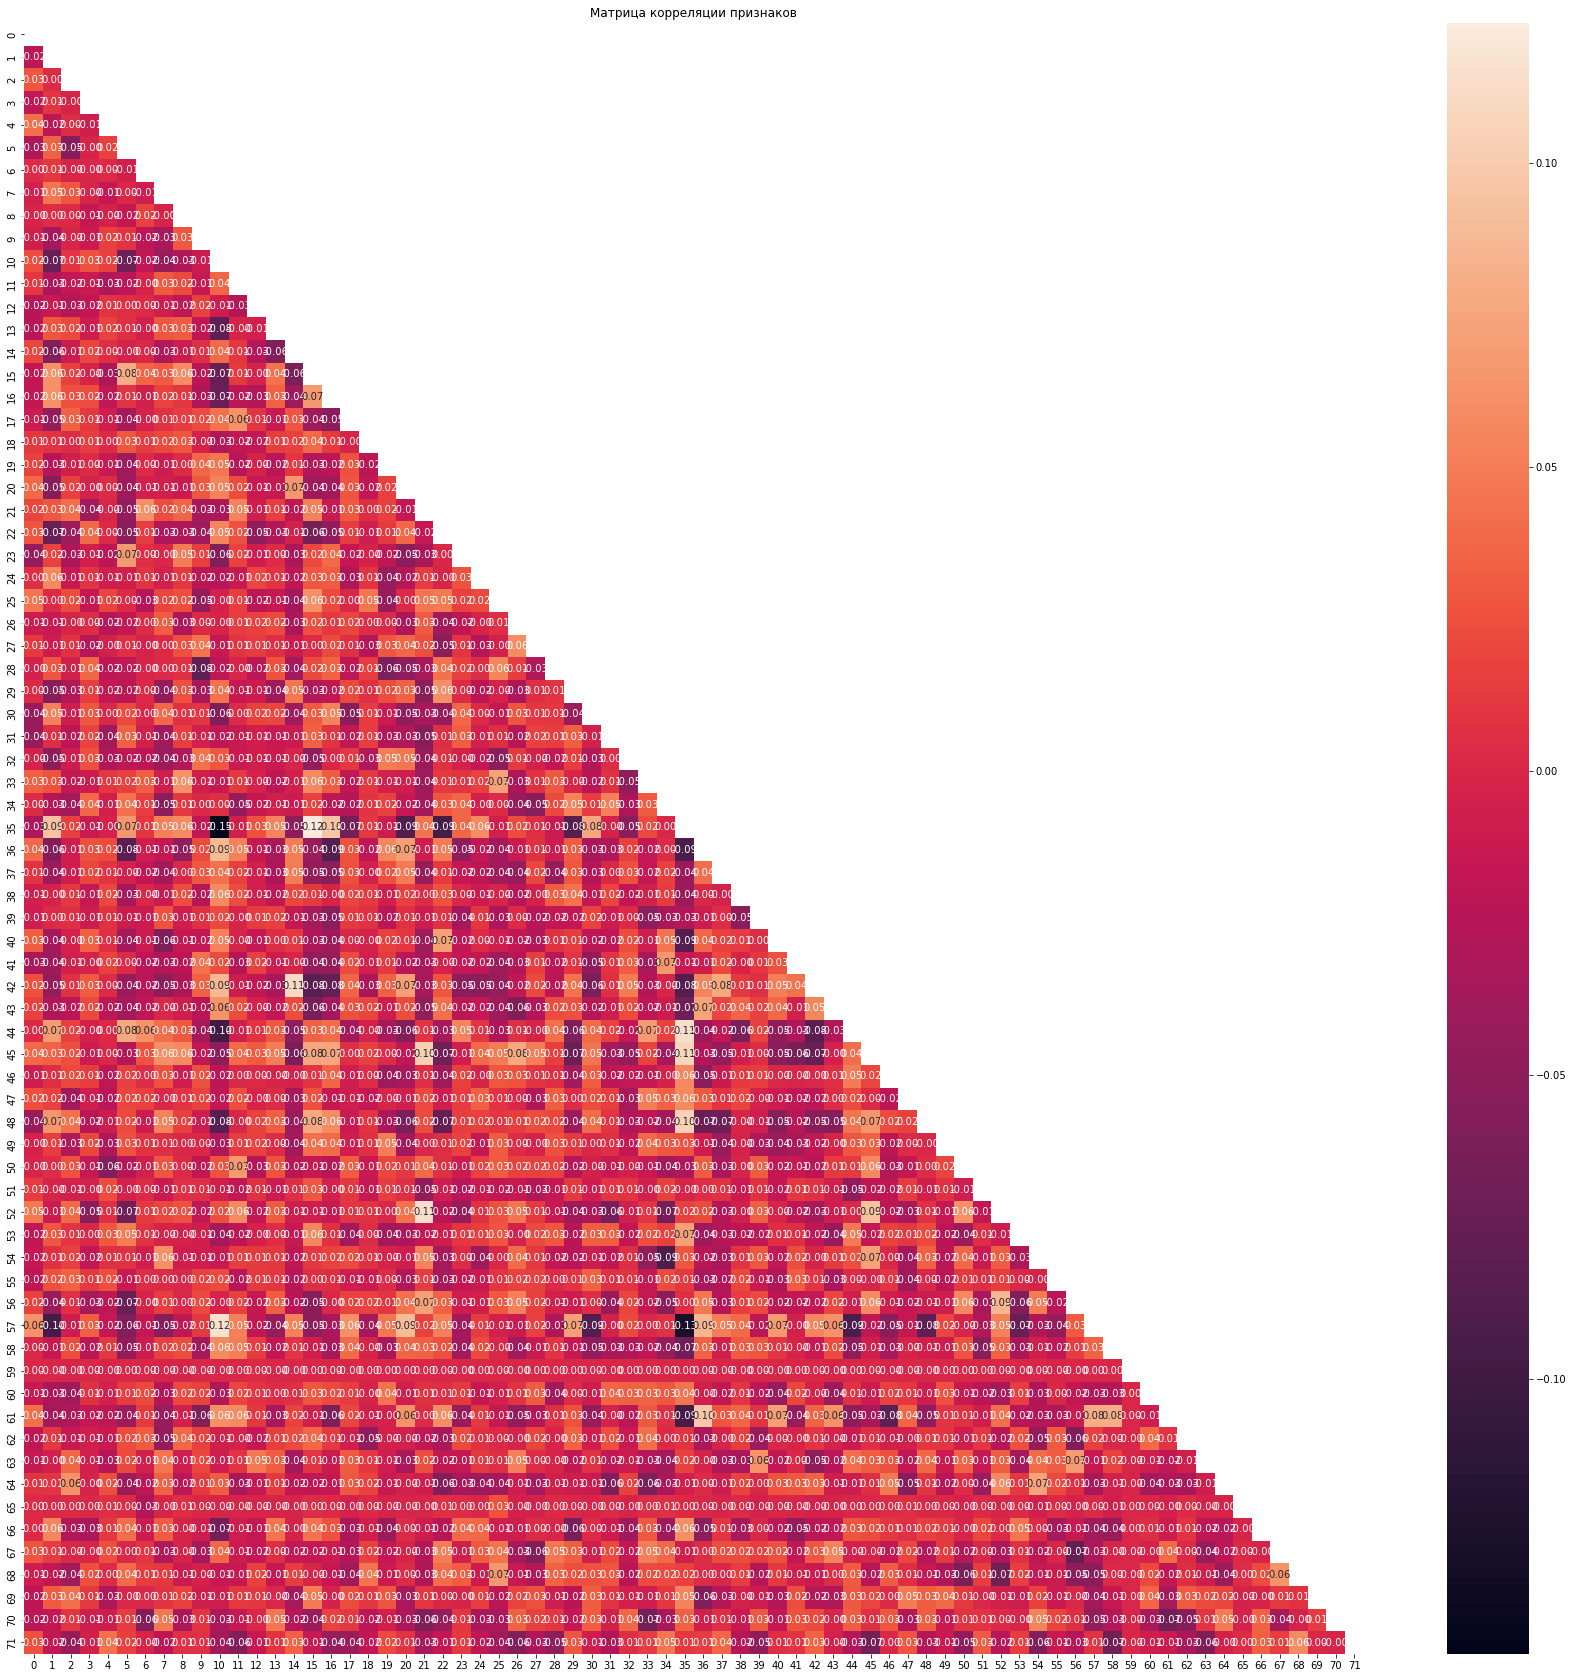

In [13]:
plt.figure(figsize=(30,30))
plt.title('Матрица корреляции признаков')
matrix = np.triu(base[columns].corr())
sns.heatmap(base[columns].corr(), annot=True, fmt='.2f', mask=matrix)
None

Признаки не коррелированы, максимальные коэффициенты корреляции составляют примерно 0.1

## Решение задачи матчинга

Создадим функцию для расчета метрики recall по 10 кандидатам для каждого вектора:

In [14]:
def recall10(I, base, target):
    '''Принимает на вход индексы кандидатов, Id векторов из base и ответы из train.
       Возвращает среднее количество матчей.
    '''

    id_base_dict = dict(base)
    predicted_list = []
    for candidates in I:
        predicted_list.append([id_base_dict[candidate] for candidate in candidates])
    
    target['preds'] = predicted_list
    target['is_true'] = target.apply(lambda x: x['Target'] in x['preds'], axis=1)

    return target['is_true'].mean()

- для определения кандидатов будем использовать все колонки, кроме 6, 21, 25, 33, 44, 59, 65 и 70;
- данные предварительно преобразуем с помощью квантильного преобразования, так как квантильное преобразование сглаживает необычные распределения и меньше подвержено влиянию выбросов, чем методы масштабирования, а также итоговая метрика с данном эксперименте получилась чуть больше, чем при масштабировании с нулевым средним значением и единичной дисперсией;
- отнормируем векторы и посчитаем их скалярное произведение, тем самым выполним поиск ближайших соседей по косиносному расстоянию.
Для большей точности проведем 'плоский' поиск:

In [15]:
model_columns = ['0', '1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13',
                 '14', '15', '16', '17', '18', '19', '20', '22', '23', '24', '26',
                 '27', '28', '29', '30', '31', '32',  '34', '35', '36', '37', '38',
                 '39', '40', '41', '42', '43', '45', '46', '47', '48', '49', '50',
                 '51', '52', '53', '54', '55', '56', '57', '58', '60', '61', '62',
                 '63', '64',  '66', '67', '68', '69',  '71']

scaler = QuantileTransformer(n_quantiles=10000, random_state=42, output_distribution='normal')
base_scaled = scaler.fit_transform(base[model_columns])
train_scaled = scaler.transform(train[model_columns])

base_scaled = np.ascontiguousarray(base_scaled, dtype='float32')
train_scaled = np.ascontiguousarray(train_scaled, dtype='float32')
faiss.normalize_L2(base_scaled )
faiss.normalize_L2(train_scaled)
index = faiss.index_factory(len(model_columns), 'Flat', faiss.METRIC_INNER_PRODUCT)
index.add(base_scaled)
topn = 10
D, I = index.search(train_scaled, topn)

recall10(I, base['Id'], train[['Target']])

0.74016

Полнота на трейне составила 0.74016

## Поиск для теста

Проведем поиск кандидатов на матч для test. Чтобы повысить recall при поиске, увеличим датасет за счет данных из train:

In [16]:
# увеличение датасета
train_df = train.iloc[:, 1:-1]
train_df.insert(0, 'Id', train['Target'])
data = pd.concat([base, train_df])
data = data.reset_index(drop=True)

# преобразование данных
scaler = QuantileTransformer(n_quantiles=10000, random_state=42, output_distribution='normal')
base_scaled = scaler.fit_transform(data[model_columns])
test_scaled = scaler.transform(test[model_columns])
base_scaled = np.ascontiguousarray(base_scaled, dtype='float32')
test_scaled = np.ascontiguousarray(test_scaled, dtype='float32')
faiss.normalize_L2(base_scaled)
faiss.normalize_L2(test_scaled)

# поиск кандидатов
index = faiss.index_factory(len(model_columns), 'Flat', faiss.METRIC_INNER_PRODUCT)
index.add(base_scaled)
topn = 10
D, I = index.search(test_scaled, topn)

# подготовка ответов
id_base_dict = dict(data['Id'])
predicted_list = []
for candidates in I:
    predicted_list.append(' '.join([id_base_dict[candidate] for candidate in candidates]))
answers = test[['Id']]
answers['Predicted'] = predicted_list
#answers.to_csv('answers.csv', index=False)